In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

We reviewed four different sources of records relating to segregation placements at the Northwest ICE Processing Center/Northwest Detention Center (NWIPC/NWDC). These include two internal datasets created by GEO Group or its employees; and two installments of data from ICE’s Segregation Review Management System (SRMS). We detail each of these sources in turn below.

The NWDC segregation datasets created by GEO Group were obtained from ICE via our ongoing FOIA lawsuit; we believe it is the first time that such internal records have been made publicly available. The first of these, with the original filename `Sep_1_2013_to_March_31_2020_SMU_geotrack_report_Redacted.pdf`, is described by US DOJ attorneys for ICE as follows:

> “The GEOtrack report that was provided to Plaintiffs runs from September 1, 2013 to March 31, 2020.  That report not only reports all placements into segregation, but it also tracks movement.  This means that if an individual is placed into one particular unit then simply moves to a different unit, it is tracked in that report (if an individual is moved from H unit cell 101 to H unit cell 102, it would reflect the move as a new placement on the report).”

We refer to this report here by the shorthand "SMU" for "Special Management Unit".

The second internal dataset, with the original filename `15_16_17_18_19_20_RHU_admission_Redacted.xlsx`, is described by US DOJ attorneys for ICE as follows:

> “The [RHU] spreadsheet runs from January 2015 to May 28, 2020 and was created by and for a lieutenant within the facility once he took over the segregation lieutenant duties. The spreadsheet is updated once a detainee departs segregation. The subjects who are included on this list, therefore, are those who were placed into segregation and have already been released from segregation. It does not include those individuals who are currently in segregation.”

We refer to this report here by the shorthand "RHU" for "Restricted Housing Unit". (US DOJ attorneys for ICE specified that the terms “Special Management Unit” and “Restricted Housing Unit” are interchangeable and identify the same locations.)

# GEOtrack report (SMU)

Original filename: `Sep_1_2013_to_March_31_2020_SMU_geotrack_report_Redacted.pdf`

The original file has been converted from PDF to CSV format using the [Xpdf pdftotext](https://www.xpdfreader.com/pdftotext-man.html) command line tool with `--table` option, and hand cleaned to correct OCR errors. The resulting CSV has been minimally cleaned in a separate process dropping 14 duplicated records; cleaning code availabe upon request.

The original file includes three redacted fields: `Alien #`, `Name`, and `Birthdate`. The file appears to be generated by a database report for the date range "9/1/2013 To 3/31/2020", presumably from the "GEOTrack" database referenced in the filename and by the DOJ attorneys for ICE.

In [56]:
smu = pd.read_csv('../input/smu.csv.gz', sep='|', quotechar='"', compression='gzip')

In [57]:
smu.head()

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour
0,GUATEMALA,H-NA-108,6/27/2013 1:31:00AM,4/9/2014 11:49:00PM,286,6/27/2013,1:31:00AM,4/9/2014,11:49:00PM
1,MEXICO,H-NA-205,8/5/2013 2:30:00PM,11/10/2014 6:34:00AM,462,8/5/2013,2:30:00PM,11/10/2014,6:34:00AM
2,MEXICO,H-NA-106,8/8/2013 10:08:00AM,9/6/2013 11:41:00AM,29,8/8/2013,10:08:00AM,9/6/2013,11:41:00AM
3,MARSHALL ISLANDS,H-NA-203,8/15/2013 11:17:00AM,9/13/2013 9:05:00AM,29,8/15/2013,11:17:00AM,9/13/2013,9:05:00AM
4,MEXICO,H-NA-209,8/15/2013 10:07:00PM,9/9/2013 12:00:00AM,25,8/15/2013,10:07:00PM,9/9/2013,12:00:00AM


In [58]:
len(smu)

3447

All dates convert successfully:

In [7]:
assert pd.to_datetime(smu['assigned_dt'], errors='coerce').isnull().sum() == 0
smu['assigned_dt'] = pd.to_datetime(smu['assigned_dt'])
assert pd.to_datetime(smu['removed_dt'], errors='coerce').isnull().sum() == 0
smu['removed_dt'] = pd.to_datetime(smu['removed_dt'])

In [62]:
smu[smu.duplicated(keep=False)]

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour
2483,MEXICO,H-NA-104,5/12/2018 2:53:00AM,5/12/2018 2:53:00AM,0,5/12/2018,2:53:00AM,5/12/2018,2:53:00AM
2484,MEXICO,H-NA-104,5/12/2018 2:53:00AM,5/12/2018 2:53:00AM,0,5/12/2018,2:53:00AM,5/12/2018,2:53:00AM
2485,MEXICO,H-NA-104,5/12/2018 2:53:00AM,5/12/2018 2:53:00AM,0,5/12/2018,2:53:00AM,5/12/2018,2:53:00AM
2486,MEXICO,H-NA-104,5/12/2018 2:53:00AM,5/12/2018 2:53:00AM,0,5/12/2018,2:53:00AM,5/12/2018,2:53:00AM
2487,MEXICO,H-NA-104,5/12/2018 2:53:00AM,5/12/2018 2:53:00AM,0,5/12/2018,2:53:00AM,5/12/2018,2:53:00AM
2705,GUATEMALA,H-NA-101,11/16/2018 1:15:00AM,11/16/2018 1:15:00AM,0,11/16/2018,1:15:00AM,11/16/2018,1:15:00AM
2706,GUATEMALA,H-NA-101,11/16/2018 1:15:00AM,11/16/2018 1:15:00AM,0,11/16/2018,1:15:00AM,11/16/2018,1:15:00AM
2876,CROATIA,H-NA-108,2/24/2019 11:27:00PM,2/24/2019 11:27:00PM,0,2/24/2019,11:27:00PM,2/24/2019,11:27:00PM
2877,CROATIA,H-NA-108,2/24/2019 11:27:00PM,2/24/2019 11:27:00PM,0,2/24/2019,11:27:00PM,2/24/2019,11:27:00PM
2973,KENYA,H-NA-110,5/8/2019 12:05:00PM,5/8/2019 12:05:00PM,0,5/8/2019,12:05:00PM,5/8/2019,12:05:00PM


Validating date fields: One record has a `removed_dt` value less than `assigned_dt`, but this is only a discrepancy in the hour values:

In [8]:
sum(smu['assigned_dt'] > smu['removed_dt'])

1

In [9]:
smu.loc[smu['assigned_dt'] > smu['removed_dt']]

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour
3446,MEXICO,H-NA-110,2020-03-31 18:28:00,2020-03-31 12:00:00,0,3/31/2020,6:28:00PM,3/31/2020,12:00:00PM


95 records have a `removed_dt` value equal to `assigned_dt`:

In [10]:
sum(smu['assigned_dt'] == smu['removed_dt'])

95

In [11]:
smu.loc[smu['assigned_dt'] == smu['removed_dt']].head()

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour
55,MEXICO,H-NA-209,2013-09-22 03:25:00,2013-09-22 03:25:00,0,9/22/2013,3:25:00AM,9/22/2013,3:25:00AM
57,MEXICO,H-NA-209,2013-09-22 03:29:00,2013-09-22 03:29:00,0,9/22/2013,3:29:00AM,9/22/2013,3:29:00AM
145,UKRAINE,H-NA-210,2013-11-08 03:30:00,2013-11-08 03:30:00,0,11/8/2013,3:30:00AM,11/8/2013,3:30:00AM
190,MOROCCO,H-NA-103,2013-11-29 02:11:00,2013-11-29 02:11:00,0,11/29/2013,2:11:00AM,11/29/2013,2:11:00AM
253,LAOS,H-NA-102,2013-12-28 20:03:00,2013-12-28 20:03:00,0,12/28/2013,8:03:00PM,12/28/2013,8:03:00PM


Recalculating segregation placement length based on date only results in same value as `days_in_seg` field.

Note that this calculation is not first day inclusive, as in the case of the RHU dataset and SRMS datasets below. We will discard hourly data and calculate first day inclusive stay lengths below for comparison purposes.

In [12]:
smu['days_calc'] = (pd.to_datetime(smu['removed_date']) - pd.to_datetime(smu['assigned_date'])) / np.timedelta64(1, 'D')
assert sum(smu['days_in_seg'] == smu['days_calc']) == len(smu)

In [13]:
smu['days_calc'].describe()

count    3447.000000
mean        9.936176
std        23.632917
min         0.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       488.000000
Name: days_calc, dtype: float64

About 16% of records reflect stay lengths of less than one day, based on placement dates.

In [14]:
sum(smu['days_calc'] < 1)

561

In [15]:
sum(smu['days_calc'] < 1) / len(smu)

0.16275021758050479

Calculating hourly segregation placement length based on datetime field gives us slightly different values; but we should discard hourly data because it is not available in other datasets for comparison, and it is unreliable as seen above.

In [16]:
smu['hours_calc'] = (smu['removed_dt'] - smu['assigned_dt']) /  np.timedelta64(1, 'h')

In [17]:
smu['hours_calc'].describe()

count     3447.000000
mean       238.731525
std        566.594120
min         -6.466667
25%         25.741667
50%         80.683333
75%        232.891667
max      11710.366667
Name: hours_calc, dtype: float64

In [18]:
sum(smu['hours_calc'] < 24)

832

GEOTrack database export timeframe appears to be based on `removed_dt` min/max values:

In [19]:
print(smu['assigned_dt'].describe(), sep='\n')

count                    3447
unique                   3297
top       2018-05-12 02:53:00
freq                        6
first     2013-06-27 01:31:00
last      2020-03-31 18:28:00
Name: assigned_dt, dtype: object


In [20]:
smu['removed_dt'].describe()

count                    3447
unique                   3303
top       2020-03-31 12:00:00
freq                       17
first     2013-09-01 18:18:00
last      2020-03-31 12:00:00
Name: removed_dt, dtype: object

In [21]:
smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['days_calc'].median()

assigned_dt
2013-01-01    3.0
2014-01-01    3.0
2015-01-01    3.0
2016-01-01    3.0
2017-01-01    4.0
2018-01-01    5.0
2019-01-01    3.5
2020-01-01    2.0
Freq: AS-JAN, Name: days_calc, dtype: float64

In [22]:
print(smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['days_calc'].mean())

assigned_dt
2013-01-01    10.785185
2014-01-01     7.831721
2015-01-01     9.393814
2016-01-01     9.889693
2017-01-01    12.404537
2018-01-01    11.061503
2019-01-01     9.427734
2020-01-01     7.176056
Freq: AS-JAN, Name: days_calc, dtype: float64


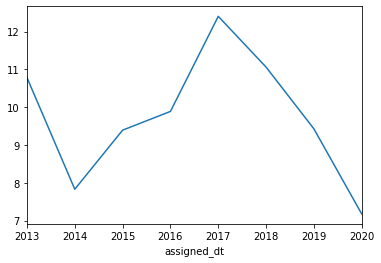

In [23]:
smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['days_calc'].mean().plot()

In [24]:
assert sum(smu['citizenship'].isnull()) == 0
smu_annual = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['citizenship'].count()

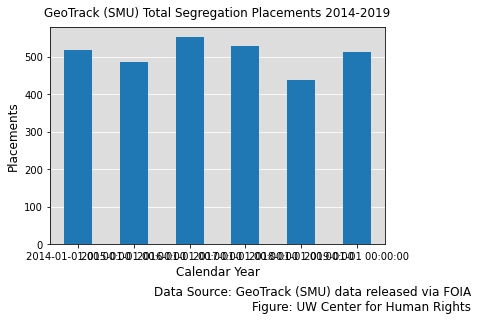

In [26]:
data = smu.set_index('assigned_dt').loc['2014':'2019']
data = data.groupby([pd.Grouper(freq='AS')])['citizenship'].count()

fig, ax = plt.subplots()

data.plot(kind='bar')

data.index = [f'{x.year}' for x in data.index]

ax.set_facecolor('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(color='#FFFFFF')

plt.title('GeoTrack (SMU) Total Segregation Placements 2014-2019', fontsize=12, pad=10)
plt.ylabel('Placements', fontsize=12)
plt.xlabel('Calendar Year', fontsize=12)
plt.xticks(rotation=0)

txt='Data Source: GeoTrack (SMU) data released via FOIA\nFigure: UW Center for Human Rights'
plt.figtext(1.1, -.1, txt, wrap=True, horizontalalignment='right', fontsize=12)

plt.show();

In [27]:
smu_annual

assigned_dt
2013-01-01    270
2014-01-01    517
2015-01-01    485
2016-01-01    553
2017-01-01    529
2018-01-01    439
2019-01-01    512
2020-01-01    142
Freq: AS-JAN, Name: citizenship, dtype: int64

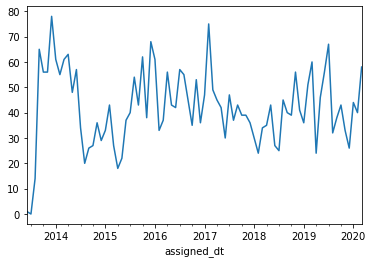

In [28]:
smu_monthly = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='M')])['citizenship'].count()
smu_monthly.plot()

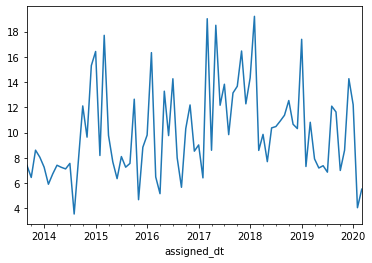

In [29]:
smu.set_index('assigned_dt').loc['2013-09-01':].groupby([pd.Grouper(freq='M')])['days_calc'].mean().plot()

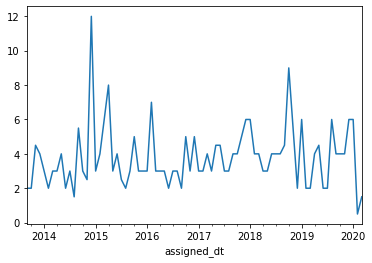

In [30]:
smu.set_index('assigned_dt').loc['2013-09-01':].groupby([pd.Grouper(freq='M')])['days_calc'].median().plot()

Stays over 14 days must be reported to ICE SRMS. Flagging long placements and calculating as percent of total placements. (Caveat: placements are by housing assignment, not cumulative stay length, so long stays are likely undercounted here.)

In [31]:
smu['long_stay'] = smu['days_calc'] > 14

In [32]:
long_g = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['long_stay'].sum()

In [33]:
count_g = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['citizenship'].count()

Long stays are increasing over time both absolutely and as proportion of total placements:

In [34]:
(long_g / count_g * 100)

assigned_dt
2013-01-01    17.777778
2014-01-01    12.765957
2015-01-01    12.989691
2016-01-01    15.370705
2017-01-01    17.769376
2018-01-01    23.917995
2019-01-01    21.679688
2020-01-01    18.309859
Freq: AS-JAN, dtype: float64

In [35]:
long_g

assigned_dt
2013-01-01     48.0
2014-01-01     66.0
2015-01-01     63.0
2016-01-01     85.0
2017-01-01     94.0
2018-01-01    105.0
2019-01-01    111.0
2020-01-01     26.0
Freq: AS-JAN, Name: long_stay, dtype: float64

In [36]:
count_g

assigned_dt
2013-01-01    270
2014-01-01    517
2015-01-01    485
2016-01-01    553
2017-01-01    529
2018-01-01    439
2019-01-01    512
2020-01-01    142
Freq: AS-JAN, Name: citizenship, dtype: int64

A [June 24-26, 2014 DHS inspection report](https://drive.google.com/file/d/1YDX4fOOJ3DCftWiQv7O_5jwA2eZ0ftWR/view?usp=sharing) for NWDC states, “Documentation reflects there were 776 assignments to segregation in the past year”. The SMU dataset covers this period, albeit with only partial records for June-Sept 2013. Total count of placements during this period is reasonably close to figure cited by DHS inspectors, which suggests an average of just over 60 placements per month. 

In [37]:
776 / 12

64.66666666666667

In [38]:
smu.set_index('assigned_dt').loc[:'2014-06-30'].groupby(pd.Grouper(freq='M'))['citizenship'].count()

assigned_dt
2013-06-30     1
2013-07-31     0
2013-08-31    14
2013-09-30    65
2013-10-31    56
2013-11-30    56
2013-12-31    78
2014-01-31    61
2014-02-28    55
2014-03-31    61
2014-04-30    63
2014-05-31    48
2014-06-30    57
Freq: M, Name: citizenship, dtype: int64

In [39]:
smu.set_index('assigned_dt').loc['2013-09-01':'2014-06-30'].groupby(pd.Grouper(freq='M'))['citizenship'].count().mean()

60.0

In [40]:
smu['assigned_dt'].min()

Timestamp('2013-06-27 01:31:00')

In [41]:
smu['removed_dt'].min()

Timestamp('2013-09-01 18:18:00')

In [42]:
len(smu.set_index('assigned_dt').loc[:'2014-06-30'])

615

In [43]:
smu.head()

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour,days_calc,hours_calc,long_stay
0,GUATEMALA,H-NA-108,2013-06-27 01:31:00,2014-04-09 23:49:00,286,6/27/2013,1:31:00AM,4/9/2014,11:49:00PM,286.0,6886.300000,True
1,MEXICO,H-NA-205,2013-08-05 14:30:00,2014-11-10 06:34:00,462,8/5/2013,2:30:00PM,11/10/2014,6:34:00AM,462.0,11080.066667,True
2,MEXICO,H-NA-106,2013-08-08 10:08:00,2013-09-06 11:41:00,29,8/8/2013,10:08:00AM,9/6/2013,11:41:00AM,29.0,697.550000,True
3,MARSHALL ISLANDS,H-NA-203,2013-08-15 11:17:00,2013-09-13 09:05:00,29,8/15/2013,11:17:00AM,9/13/2013,9:05:00AM,29.0,693.800000,True
4,MEXICO,H-NA-209,2013-08-15 22:07:00,2013-09-09 00:00:00,25,8/15/2013,10:07:00PM,9/9/2013,12:00:00AM,25.0,577.883333,True


In [44]:
len(smu['housing'].unique())

20

In [52]:
smu.set_index('assigned_dt').groupby(pd.Grouper(freq='AS'))['housing'].nunique()

assigned_dt
2013-01-01    20
2014-01-01    20
2015-01-01    20
2016-01-01    20
2017-01-01    20
2018-01-01    20
2019-01-01    20
2020-01-01    20
Freq: AS-JAN, Name: housing, dtype: int64

In [54]:
smu['housing'].value_counts()

H-NA-104    246
H-NA-107    246
H-NA-101    242
H-NA-103    237
H-NA-102    236
H-NA-109    228
H-NA-105    228
H-NA-110    213
H-NA-108    211
H-NA-106    210
H-NA-210    156
H-NA-208    139
H-NA-203    130
H-NA-209    130
H-NA-204    126
H-NA-202    123
H-NA-201    121
H-NA-207     99
H-NA-206     74
H-NA-205     52
Name: housing, dtype: int64

# RHU

Original file: `15_16_17_18_19_20_RHU_admission_Redacted.xlsx`

Log created and maintained by hand by GEO employee to track Restricted Housing Unit placements. Described by US DOJ attorneys for ICE as follows:

> “The [RHU] spreadsheet runs from January 2015 to May 28, 2020 and was created by and for a lieutenant within the facility once he took over the segregation lieutenant duties. The spreadsheet is updated once a detainee departs segregation. The subjects who are included on this list, therefore, are those who were placed into segregation and have already been released from segregation. It does not include those individuals who are currently in segregation.”

## Dates and total days calculation

Inspection of the original Excel file suggests that the `Total days` column values are incorrect throughout, based on a broken cell formula. For example, on the "2020" spreadsheet tab, the `Total days` column values are integers which only occasionally align with calculated placement length based on the `Date in` and `Date out` columns. However, additional spreadsheet rows at the bottom of the sheet not containing values in other fields contain an Excel formula ("=(D138-C138)+1") which should have been used to calculate these values. Comparing calculated stay lengths with reported `Total days` suggests that this formula was not updated consistently, causing fields to become misaligned. Additionally, the "2015" spreadsheet tab includes many `Total days` values equal to "1", suggesting that the formula was applied incorrectly or with missing data.

We can recalculate actual stay lengths based on the formula cited above (including start days, with stays of less than one day calculated as "1"); or with the formula used for the "SMU" records above (excluding start days, with  stays of less than one day calculated as "0"), for more consistent comparison with other datasets.

The above issue raises the possibility that other fields in addition to `Total days` may be misaligned in the original dataset. One fact mitigating this possibility is that no `Date out` values predate associated `Date in` values. We can also look more closely at qualitative fields to make an educated guess as to the data quality: for example, do `intial_placement` values suggesting disciplinary placements align with `placement_reason` values also consistent with disciplinary placements? However, we do not intend to use this dataset for detailed qualitative analysis; of most interest are total segregation placements and segregation stay lengths.

In [128]:
rhu = pd.read_csv('../input/rhu.csv.gz', sep='|', quotechar='"', compression='gzip')

In [129]:
rhu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               2532 non-null   object
 1   alien_#            2532 non-null   object
 2   date_in            2532 non-null   object
 3   date_out           2532 non-null   object
 4   total_days         2532 non-null   int64 
 5   initial_placement  2532 non-null   object
 6   placement_reason   2532 non-null   object
 7   disc_seg           2532 non-null   object
 8   release_reason     2532 non-null   object
dtypes: int64(1), object(8)
memory usage: 178.2+ KB


In [130]:
rhu.head()

,name,alien_#,date_in,date_out,total_days,initial_placement,placement_reason,disc_seg,release_reason
0,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/3/2015,1/5/2015,20,pending hearing,refusing staff orders,N,release to gen pop
1,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/10/2015,1/12/2015,294,pending hearing,assault,N,release from custody
2,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/12/2015,1/16/2015,8,pending hearing,disrupting facility operations,Y,released to medical
3,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/13/2015,1/29/2015,3,pending hearing,assault,Y,release to gen pop
4,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/14/2015,2/6/2015,4,security risk,"(b)(6), (b)(7)(C), (b)(7)(E)",N,release from custody


In [131]:
rhu['date_in'] = pd.to_datetime(rhu['date_in'])
rhu['date_out'] = pd.to_datetime(rhu['date_out'])

As noted above, no `date_out` values predate associated `date_in` values:

In [132]:
assert sum(rhu['date_in'] > rhu['date_out']) == 0

Here we recalculate the `total days` field based on the first day inclusive formula in the original spreadsheet ("=(D138-C138)+1"):

In [133]:
rhu['total_days_calc'] = (rhu['date_out'] - rhu['date_in']) / np.timedelta64(1, 'D') + 1

Less than 10% of `total_days` values match `total_days_calc`:

In [134]:
sum(rhu['total_days_calc'] == rhu['total_days']) / len(rhu) * 100

8.175355450236967

Note that the summary statistics for the original field (`total_days`) are very similar to the recalculated field (`total_days_calc`), suggesting that most values are present in the dataset but misaligned:

In [135]:
rhu['total_days'].describe()

count    2532.000000
mean       13.579384
std        37.031862
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       694.000000
Name: total_days, dtype: float64

In [136]:
rhu['total_days_calc'].describe()

count    2532.000000
mean       14.777646
std        37.624797
min         1.000000
25%         3.000000
50%         5.000000
75%        12.000000
max       694.000000
Name: total_days_calc, dtype: float64

The symmetrical distribution of values when analyzing the difference between the fields also suggests that values are largely misaligned rather than miscalculated:

In [137]:
(rhu['total_days_calc'] - (rhu['total_days'])).describe()

count    2532.000000
mean        1.198262
std        53.309465
min      -692.000000
25%        -4.000000
50%         1.000000
75%         6.000000
max       693.000000
dtype: float64

Therefore, we will conclude that it is correct to recalculate the `total_days` field here. We will follow the first day inclusive formula suggested in the original dataset here: 

In [138]:
rhu['total_days'] = (rhu['date_out'] - rhu['date_in']) / np.timedelta64(1, 'D') + 1

In [139]:
rhu = rhu.drop('total_days_calc', axis=1)

In [140]:
rhu['total_days'].describe()

count    2532.000000
mean       14.777646
std        37.624797
min         1.000000
25%         3.000000
50%         5.000000
75%        12.000000
max       694.000000
Name: total_days, dtype: float64

In [141]:
assert sum(pd.isnull(rhu['name'])) == 0

In [142]:
rhu_annual = rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['name'].count()

In [143]:
rhu_monthly = rhu.set_index('date_in').groupby(pd.Grouper(freq='M'))['name'].count()

In [144]:
rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['total_days'].mean()

date_in
2015-01-01    14.698061
2016-01-01    12.855530
2017-01-01    17.704120
2018-01-01    14.645763
2019-01-01    14.980769
2020-01-01     9.632353
Freq: AS-JAN, Name: total_days, dtype: float64

# RHU/SMU comparison

In [145]:
data = pd.concat([rhu_annual, smu_annual], axis=1)

In [146]:
data.columns = ['RHU', 'SMU']

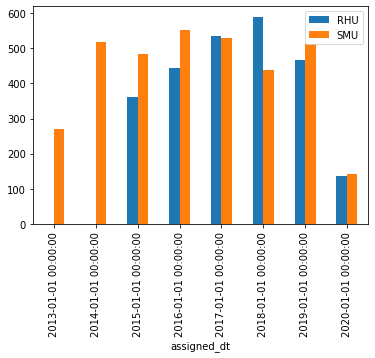

In [147]:
data.plot(kind='bar')

In [148]:
data

,RHU,SMU
assigned_dt,,
2013-01-01,NaN,270
2014-01-01,NaN,517
2015-01-01,361.0,485
2016-01-01,443.0,553
2017-01-01,534.0,529
2018-01-01,590.0,439
2019-01-01,468.0,512
2020-01-01,136.0,142


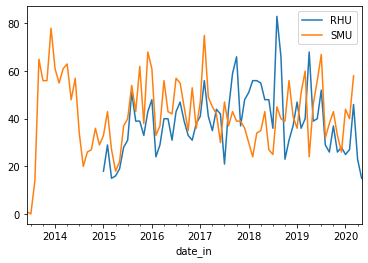

In [149]:
data = pd.concat([rhu_monthly, smu_monthly], axis=1)
data.columns = ['RHU', 'SMU']
data.plot()

The Segregation Review Management System (SRMS) datasets are maintained by ICE based on segregation placements reported under ICE's national guidelines, including placements for longer than 14 days (or 14 days during a 21-day period) and involving people with “special vulnerabilities.” UWCHR received two installments of SRMS data for NWDC: the first, released in 2019, covers the period from 2013-05-13 to 2018-05-14; the second, released in 2020, covers the period from 2013-09-03 to 2020-03-16.

The SRMS is the only available source of data for national-level analysis of segregation placements and comparisons between various detention facilities. Two investigative journalism and advocacy organizations, the International Consortium for Investigative Journalism (ICIJ) and Project On Government Oversight (POGO), have released national SRMS datasets covering different time periods.

SRMS data is examined more closely elsewhere.

# SRMS data

In [150]:
srms_1 = pd.read_csv('../input/srms-1.csv.gz', sep='|', compression='gzip')
srms_2 = pd.read_csv('../input/srms-2.csv.gz', sep='|', compression='gzip')

In [151]:
srms_1.columns

Index(['tracking_number', 'gender', 'country_of_citizenship', 'facility_aor',
       'facility', 'facility:detloc', 'report_type', 'placement_date',
       'placement_reason', 'release_date', 'length_of_stay',
       'disciplinary_infraction', 'sanction_length', 'attorney_of_record',
       'attorney_notification', 'detainee_request',
       'compliance_with_detention_standards', 'mental_illness',
       'serious_medical_illness', 'serious_disability', 'ever_smi',
       'non_compliance_detail', 'special_criteria', 'id', 'current_review',
       'created', 'lgbti', 'item_type', 'placement_reason_type',
       'admin_or_disciplinary', 'detloc'],
      dtype='object')

In [152]:
srms_1['placement_date'] = pd.to_datetime(srms_1['placement_date'])
srms_1['release_date'] = pd.to_datetime(srms_1['release_date'])
srms_2['placement_date'] = pd.to_datetime(srms_2['placement_date'])
srms_2['release_date'] = pd.to_datetime(srms_2['release_date'])

In [153]:
srms_1['days_calc'] = (srms_1['release_date'] - srms_1['placement_date']) / np.timedelta64(1, 'D')
srms_2['days_calc'] = (srms_2['release_date'] - srms_2['placement_date']) / np.timedelta64(1, 'D')

There are no SRMS records with placement and release on same day; this suggests comparison with first-day-inclusive calculation for stay length for SMU/RHU records.

In [154]:
srms_1['days_calc'].describe()

count    357.000000
mean      59.605042
std       88.263162
min        1.000000
25%       19.000000
50%       30.000000
75%       62.000000
max      781.000000
Name: days_calc, dtype: float64

In [155]:
srms_2['days_calc'].describe()

count    459.000000
mean      59.052288
std       76.574175
min        1.000000
25%       20.000000
50%       31.000000
75%       66.000000
max      691.000000
Name: days_calc, dtype: float64

In [156]:
srms_1_annual = srms_1.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['tracking_number'].count()
srms_2_annual = srms_2.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['tracking_number'].count()
srms_1_monthly = srms_1.set_index('placement_date').groupby(pd.Grouper(freq='M'))['tracking_number'].count()
srms_2_monthly = srms_2.set_index('placement_date').groupby(pd.Grouper(freq='M'))['tracking_number'].count()

A close review of these various datasets gives us an overview of solitary confinement practices at the NWDC, but also raises further questions about consistency of record-keeping and reporting. While the datasets are not directly comparable, and lack unique or consistent identifiers that would allow de-duplication across datasets; there are some characteristics we would expect if record-keeping and reporting was consistent:

- Between the GEO-created datasets for segregation placements at NWDC, SMU would be expected to show more and shorter placements than RHU, because it tracks specific placement locations within the NWDC; however, this would depend on frequency of transfers of detained people within SMU/RHU.

While this is true for most years, we find that in 2017 & 2018 the RHU dataset reports more total placements than SMU. This could reflect differences in record-keeping, or less frequent transfers of detained people within solitary housing during this time. Without individual indentifiers, this is difficult to assess.

- SRMS should contain approximately the same number of long placements as SMU and RHU datasets, based on requirement to report stays longer than 14 days; plus any shorter placements involving populations with “special vulnerabilities.”

We also find that the SMU and RHU datasets include significantly more stays longer than 14 days than those reported in the SRMS datasets. This might be explained if multiple placements of the same individual tracked as multiple entries in the GEO internal reports are reported to ICE SRMS as a single entry. Comparing total reported days for long stays, the relationship is less consistent; but either SMU or RHU always reflect more total days associated with long stays than SRMS. While not conclusive, the data is suggestive of underreporting of long solitary placements in ICE SRMS records for NWDC.

## Comparison of placement counts

In [157]:
data = pd.concat([rhu_annual, smu_annual, srms_1_annual, srms_2_annual], axis=1)

In [158]:
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']

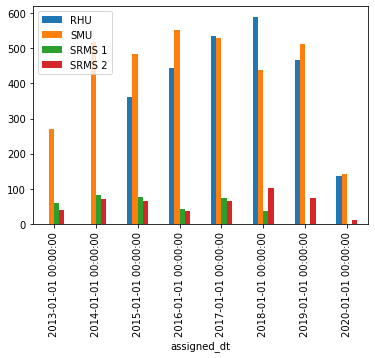

In [159]:
data.plot(kind='bar')

In [160]:
data

,RHU,SMU,SRMS 1,SRMS 2
assigned_dt,,,,
2013-01-01,NaN,270,60.0,41
2014-01-01,NaN,517,82.0,70
2015-01-01,361.0,485,76.0,66
2016-01-01,443.0,553,42.0,38
2017-01-01,534.0,529,74.0,66
2018-01-01,590.0,439,37.0,101
2019-01-01,468.0,512,NaN,75
2020-01-01,136.0,142,NaN,10


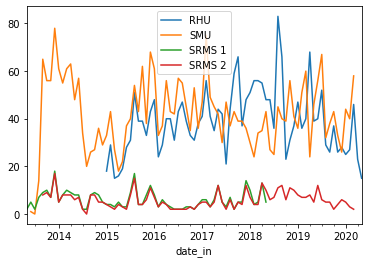

In [161]:
data = pd.concat([rhu_monthly, smu_monthly, srms_1_monthly, srms_2_monthly], axis=1)
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']
data.plot()

## Comparison avg. placement length over time

In [162]:
smu_mean = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='Q')])['days_calc'].mean()

In [163]:
rhu_mean = rhu.set_index('date_in').groupby([pd.Grouper(freq='Q')])['total_days'].mean()

In [164]:
srms_1_mean = srms_1.set_index('placement_date').groupby([pd.Grouper(freq='Q')])['days_calc'].mean()

In [165]:
srms_2_mean = srms_2.set_index('placement_date').groupby([pd.Grouper(freq='Q')])['days_calc'].mean()

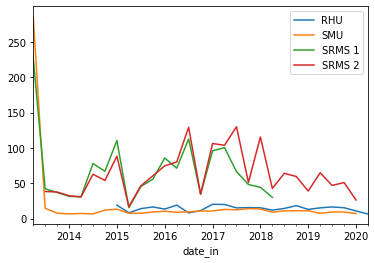

In [166]:
data = pd.concat([rhu_mean, smu_mean, srms_1_mean, srms_2_mean], axis=1)
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']
data.plot()

In [167]:
data

,RHU,SMU,SRMS 1,SRMS 2
date_in,,,,
2013-06-30,NaN,286.000000,227.142857,NaN
2013-09-30,NaN,14.620253,42.222222,38.375000
2013-12-31,NaN,7.742105,36.942857,37.606061
2014-03-31,NaN,6.655367,31.521739,32.285714
2014-06-30,NaN,7.267857,30.880000,30.761905
2014-09-30,NaN,6.650000,77.833333,62.700000
2014-12-31,NaN,12.152174,66.954545,54.000000
2015-03-31,19.064516,13.320388,110.454545,88.333333
2015-06-30,8.222222,7.532468,15.454545,16.777778


## Comparing "long stays"

Solitary placements longer than 14 days should be reported to SRMS. Yet GEO records consistently report more long stays than long stays reflected in SRMS

In [168]:
rhu['long_stay'] = rhu['total_days'] > 14

In [169]:
srms_1['long_stay'] = srms_1['days_calc'] > 14
srms_2['long_stay'] = srms_2['days_calc'] > 14

In [170]:
rhu_long = rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['long_stay'].sum()

In [171]:
smu_long = smu.set_index('assigned_dt').groupby(pd.Grouper(freq='AS'))['long_stay'].sum()

In [172]:
srms_1_long = srms_1.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['long_stay'].sum()
srms_2_long = srms_2.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['long_stay'].sum()

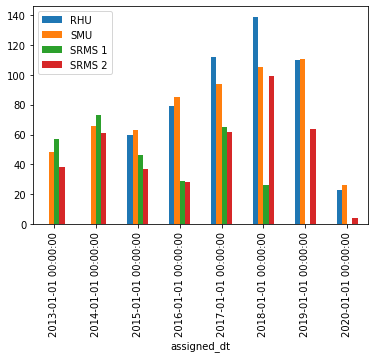

In [173]:
data = pd.concat([rhu_long, smu_long, srms_1_long, srms_2_long], axis=1)
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']
data.plot(kind='bar')

In [174]:
data

,RHU,SMU,SRMS 1,SRMS 2
assigned_dt,,,,
2013-01-01,NaN,48.0,57.0,38.0
2014-01-01,NaN,66.0,73.0,61.0
2015-01-01,60.0,63.0,46.0,37.0
2016-01-01,79.0,85.0,29.0,28.0
2017-01-01,112.0,94.0,65.0,62.0
2018-01-01,139.0,105.0,26.0,99.0
2019-01-01,110.0,111.0,NaN,64.0
2020-01-01,23.0,26.0,NaN,4.0


### Comparison of only long RHU/SMU stays versus all SRMS stays

Counting only long stays only, RHU and SMU consistently report more placements than all stays reported to SRMS (note timelines do not align for all four datasets):

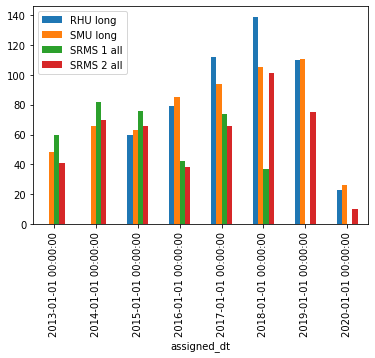

In [175]:
data = pd.concat([rhu_long, smu_long, srms_1_annual, srms_2_annual], axis=1)
data.columns = ['RHU long', 'SMU long', 'SRMS 1 all', 'SRMS 2 all']
data.plot(kind='bar')

In [176]:
data

,RHU long,SMU long,SRMS 1 all,SRMS 2 all
assigned_dt,,,,
2013-01-01,NaN,48.0,60.0,41
2014-01-01,NaN,66.0,82.0,70
2015-01-01,60.0,63.0,76.0,66
2016-01-01,79.0,85.0,42.0,38
2017-01-01,112.0,94.0,74.0,66
2018-01-01,139.0,105.0,37.0,101
2019-01-01,110.0,111.0,NaN,75
2020-01-01,23.0,26.0,NaN,10


In [177]:
rhu['long_stay'].sum() / len(rhu)

0.20655608214849921

In [178]:
smu['long_stay'].sum() / len(smu)

0.1734841891499855

In [179]:
srms_1['long_stay'].sum() / len(srms_1)

0.7978436657681941

In [180]:
srms_2['long_stay'].sum() / len(srms_2)

0.841541755888651

In [181]:
len(rhu)

2532

In [182]:
len(srms_2)

467

# Join datasets

In [183]:
smu.columns

Index(['citizenship', 'housing', 'assigned_dt', 'removed_dt', 'days_in_seg',
       'assigned_date', 'assigned_hour', 'removed_date', 'removed_hour',
       'days_calc', 'hours_calc', 'long_stay'],
      dtype='object')

In [244]:
smu_ex = smu[['assigned_date', 'removed_date']].copy()
smu_ex = smu_ex.rename({'assigned_date': 'placement_date', 'removed_date': 'release_date'}, axis=1) 
smu_ex.loc[:,'placement_date'] = pd.to_datetime(smu_ex['placement_date'])
smu_ex.loc[:,'release_date'] = pd.to_datetime(smu_ex['release_date'])
smu_ex['dataset'] = 'SMU'

# First day exclusive:
# smu_ex['days_calc'] = (smu_ex['release_date'] - smu_ex['placement_date']) / np.timedelta64(1, 'D')

# First day inclusive:
smu_ex['days_calc'] = (smu_ex['release_date'] - smu_ex['placement_date']) / np.timedelta64(1, 'D') + 1

In [245]:
rhu.columns

Index(['name', 'alien_#', 'date_in', 'date_out', 'total_days',
       'initial_placement', 'placement_reason', 'disc_seg', 'release_reason',
       'long_stay'],
      dtype='object')

In [246]:
rhu_ex = rhu[['date_in', 'date_out']].copy()
rhu_ex = rhu_ex.rename({'date_in': 'placement_date', 'date_out': 'release_date'}, axis=1)
rhu_ex['dataset'] = 'RHU'
# First day inclusive:
rhu_ex['days_calc'] = (rhu_ex['release_date'] - rhu_ex['placement_date']) / np.timedelta64(1, 'D') + 1

In [247]:
srms_1.columns

Index(['tracking_number', 'gender', 'country_of_citizenship', 'facility_aor',
       'facility', 'facility:detloc', 'report_type', 'placement_date',
       'placement_reason', 'release_date', 'length_of_stay',
       'disciplinary_infraction', 'sanction_length', 'attorney_of_record',
       'attorney_notification', 'detainee_request',
       'compliance_with_detention_standards', 'mental_illness',
       'serious_medical_illness', 'serious_disability', 'ever_smi',
       'non_compliance_detail', 'special_criteria', 'id', 'current_review',
       'created', 'lgbti', 'item_type', 'placement_reason_type',
       'admin_or_disciplinary', 'detloc', 'days_calc', 'long_stay'],
      dtype='object')

In [248]:
srms_1_ex = srms_1[['placement_date', 'release_date']].copy()
srms_1_ex['dataset'] = 'SRMS 1'
# SRMS datasets are already first day inclusive:
srms_1_ex['days_calc'] = (srms_1_ex['release_date'] - srms_1_ex['placement_date']) / np.timedelta64(1, 'D')

srms_2_ex = srms_2[['placement_date', 'release_date']].copy()
srms_2_ex['dataset'] = 'SRMS 2'
# SRMS datasets are already first day inclusive:
srms_2_ex['days_calc'] = (srms_2_ex['release_date'] - srms_2_ex['placement_date']) / np.timedelta64(1, 'D')

In [249]:
df = pd.concat([smu_ex, rhu_ex, srms_1_ex, srms_2_ex], axis=0)

In [250]:
df = df.dropna()

In [251]:
df['long_stay'] = df['days_calc'] > 14

In [252]:
table = pd.DataFrame()

In [253]:
table['total'] = df.groupby(['dataset'])['placement_date'].count()
table['min_date'] = df.groupby(['dataset'])['placement_date'].min()
table['max_date'] = df.groupby(['dataset'])['placement_date'].max()
table['avg_length'] = df.groupby(['dataset'])['days_calc'].mean()
table['med_length'] = df.groupby(['dataset'])['days_calc'].median()
table['min_length'] = df.groupby(['dataset'])['days_calc'].min()
table['max_length'] = df.groupby(['dataset'])['days_calc'].max()
# table['total_days'] = df.groupby(['dataset'])['days_calc'].sum()
table['total_long'] = df.groupby(['dataset'])['long_stay'].sum()
# table['pct_long'] = (df.groupby(['dataset'])['long_stay'].sum()) / (df.groupby(['dataset'])['placement_date'].count())

In [254]:
table

,total,min_date,max_date,avg_length,med_length,min_length,max_length,total_long
dataset,,,,,,,,
RHU,2532,2015-01-03,2020-05-28,14.777646,5.0,1.0,694.0,523.0
SMU,3447,2013-06-27,2020-03-31,10.936176,4.0,1.0,489.0,649.0
SRMS 1,357,2013-05-13,2018-05-14,59.605042,30.0,1.0,781.0,296.0
SRMS 2,459,2013-09-03,2020-03-16,59.052288,31.0,1.0,691.0,393.0


In [255]:
table.to_csv('../output/dataset_description.csv')

In [280]:
d = df[df['dataset'] != 'SRMS 1']
d = d[d['long_stay'] == True]
d = d.set_index('placement_date').loc['2015-01-03': '2020-03-16']

In [274]:
g = d.groupby([pd.Grouper(freq='AS'), 'dataset'])['long_stay'].sum().unstack()

Both SMU and RHU datasets show significantly more stays longer than 14 days than reported to SRMS during same time period (calculating first day exclusive stay lengths for SMU doesn't change this relationship):

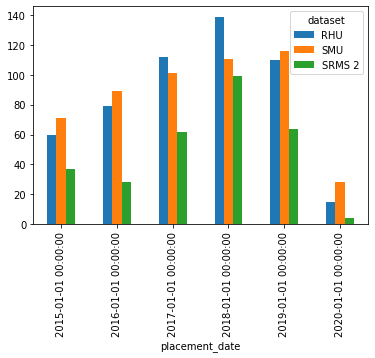

In [272]:
g.plot(kind='bar')

In [259]:
g

dataset,RHU,SMU,SRMS 2
placement_date,,,
2015-01-01,60.0,71.0,37.0
2016-01-01,79.0,89.0,28.0
2017-01-01,112.0,101.0,62.0
2018-01-01,139.0,111.0,99.0
2019-01-01,110.0,116.0,64.0
2020-01-01,15.0,28.0,4.0


In [260]:
d = df[df['dataset'] != 'SRMS 1']
d = d[d['long_stay'] == True]
d = d.set_index('placement_date').loc['2015-01-03':'2020-03-16']

In [261]:
g = d.groupby([pd.Grouper(freq='AS'), 'dataset'])['days_calc'].sum().unstack()

Counting total days of solitary placements associated with long stays, the relationship is less consistent, but either SMU or RHU always reflect more total days associated with long stays than SRMS:

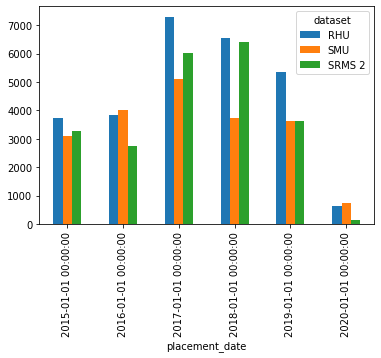

In [262]:
g.plot(kind='bar')

In [239]:
g.sum()

dataset
RHU       27393.0
SMU       19362.0
SRMS 2    22214.0
dtype: float64

In [240]:
df[df['dataset'] == 'SRMS 2'].set_index('placement_date').loc['2015-01-03':'2020-03-16']['days_calc'].sum()

22634.0

In [241]:
d = df[df['dataset'] != 'SRMS 1']
d = d.set_index('placement_date').loc['2015-01-03':'2020-03-16']

In [242]:
g = d.groupby([pd.Grouper(freq='AS'), 'dataset'])['days_calc'].sum().unstack()

Looking at all placements including short placements, RHU and SMU usually report more total days than reported to SRMS, except during 2018 in the case of SMU:

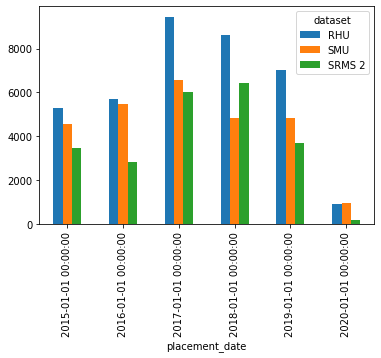

In [243]:
g.plot(kind='bar')